## DATA-255 Deep Learning | Basic GANs | Part 1

GitHub Link : https://github.com/jyanimaulik/Deep-Learning/tree/main/Homework%205

#### Step 1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:33<00:00, 798603.41it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 187142.68it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 559689.66it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8752443.04it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`.

In [ ]:
# sample tensor from the data

img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

As we can see the pixel values range from -1 to 1.

In [ ]:
# Function to denormalize the images
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
# install matplotlib to plot the images
!pip install matplotlib

Label: 9


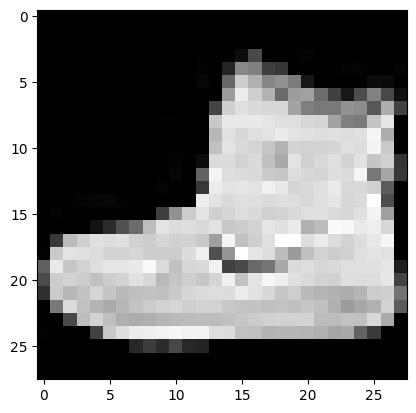

In [ ]:
# Showing the Image
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

##### Create the dataloader to load the images in batches.

In [ ]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 2, 9, 5, 5, 0, 2, 5, 3, 3, 2, 5, 7, 9, 6, 8, 0, 3, 7, 4, 8, 9, 1, 7,
        1, 2, 4, 1, 1, 3, 8, 2, 0, 5, 0, 4, 0, 5, 0, 1, 9, 1, 7, 2, 5, 0, 6, 5,
        1, 6, 5, 3, 3, 1, 4, 0, 2, 5, 0, 8, 3, 6, 1, 6, 0, 2, 2, 9, 2, 3, 0, 2,
        6, 4, 9, 4, 7, 0, 5, 1, 0, 4, 7, 3, 7, 7, 9, 7, 7, 5, 7, 8, 9, 3, 4, 5,
        9, 9, 4, 4])


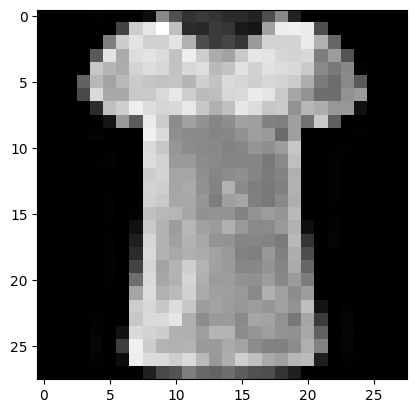

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

##### Create a device which can be used to move the data and models to a GPU, if one is available.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated".

We have used the simple feedforward network with 4 linear layers. We'll treat each 28x28 image as a vector of size 784.

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

### Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image.

we have used the feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

##### Showing Images from Generator Network

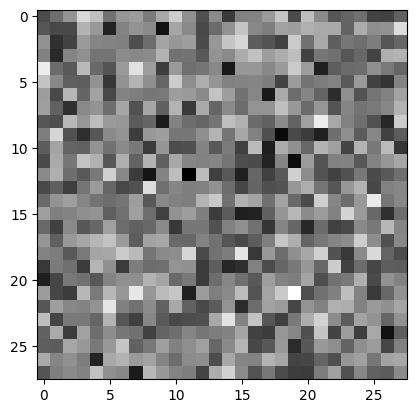

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

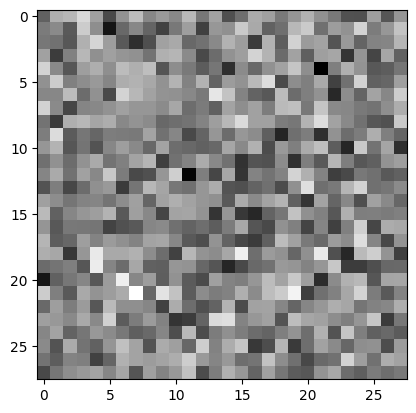

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

The output from the generator is basically random noise.

So we will define the helper function which can save a batch of outputs from the generator to the file.

In [ ]:
# moving the generator to the chosen device.
G.to(device);

### Discriminator Training

The discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.


In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

##### Defining helper functions to reset gradients.

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

##### Defining helper functions to train the discriminator.

In [ ]:
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for the real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for the fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine the losses
    d_loss = d_loss_real + d_loss_fake
    # Reset the gradients
    reset_grad()
    # Compute the gradients
    d_loss.backward()
    # Adjust the parameters using the backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real FashionMNIST dataset, and 0 if it was generated.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`d_optimizer` only affects the `D.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

Here's what this looks like in code.

##### Defining the Optimizer for generator

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

##### Defining helper functions to train the generator.

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

#### Step 2. Train the GAN model to produce images in this new domain.

In [ ]:
import os

# create a 'samples' directory where we can save intermediate outputs from the generator to visually inspect the progress of the model
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Save the batch of the real images, so can be use for the visual comparison by looking at the generated images.

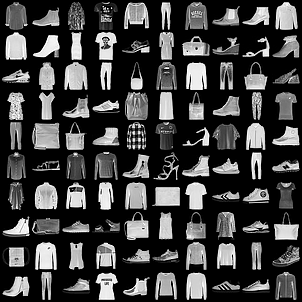

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some of the real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


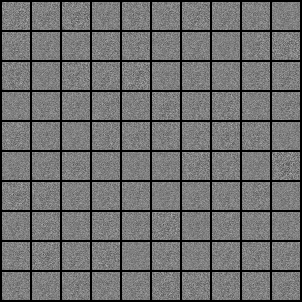

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator.

In [ ]:
%%time

num_epochs = 400
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/400], Step [200/600], d_loss: 0.1092, g_loss: 3.3842, D(x): 0.98, D(G(z)): 0.08
Epoch [0/400], Step [400/600], d_loss: 0.1299, g_loss: 5.2721, D(x): 0.95, D(G(z)): 0.06
Epoch [0/400], Step [600/600], d_loss: 0.1016, g_loss: 4.0286, D(x): 0.97, D(G(z)): 0.06
Saving fake_images-0001.png
Epoch [1/400], Step [200/600], d_loss: 0.0554, g_loss: 4.3906, D(x): 0.97, D(G(z)): 0.02
Epoch [1/400], Step [400/600], d_loss: 0.0576, g_loss: 4.3384, D(x): 0.98, D(G(z)): 0.02
Epoch [1/400], Step [600/600], d_loss: 0.0550, g_loss: 5.0832, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/400], Step [200/600], d_loss: 0.0499, g_loss: 6.0785, D(x): 0.98, D(G(z)): 0.01
Epoch [2/400], Step [400/600], d_loss: 0.0079, g_loss: 9.3564, D(x): 1.00, D(G(z)): 0.00
Epoch [2/400], Step [600/600], d_loss: 0.0303, g_loss: 5.9937, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/400], Step [200/600], d_loss: 0.1711, g_loss: 6.6335, D(x): 0.96, D(G(z)): 0.04
Epoch [3/400], Step [400/6

#### Step 3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Here below are the generated images, after the 10th, 50th, 110th, 200th, 310th and 400th epochs of training.

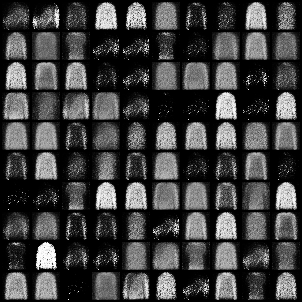

In [ ]:
Image('./samples/fake_images-0010.png')

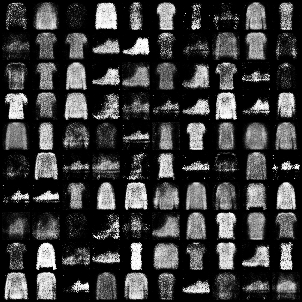

In [ ]:
Image('./samples/fake_images-0050.png')

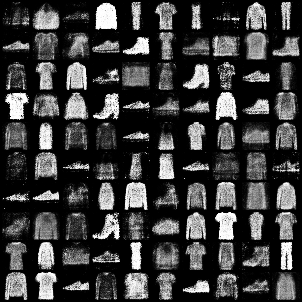

In [ ]:
Image('./samples/fake_images-0110.png')

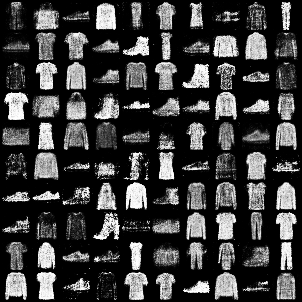

In [ ]:
Image('./samples/fake_images-0200.png')

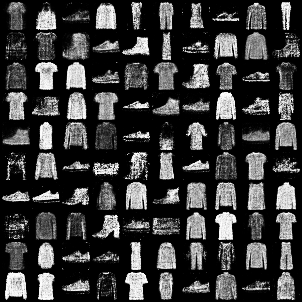

In [ ]:
Image('./samples/fake_images-0310.png')

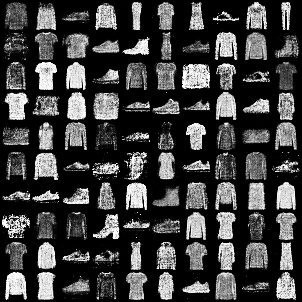

In [ ]:
Image('./samples/fake_images-0400.png')

#### Losses of Discriminator and Generator

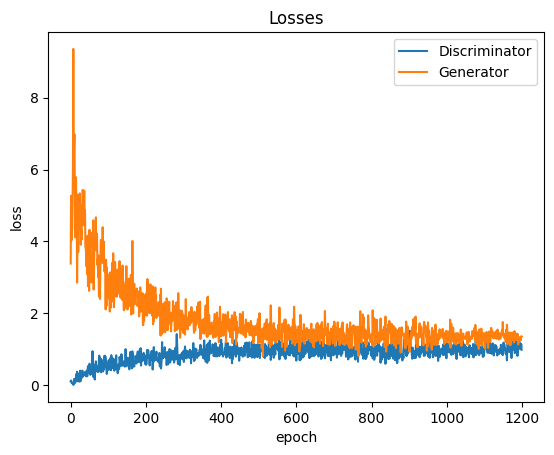

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

#### Real Score Vs Fake Score

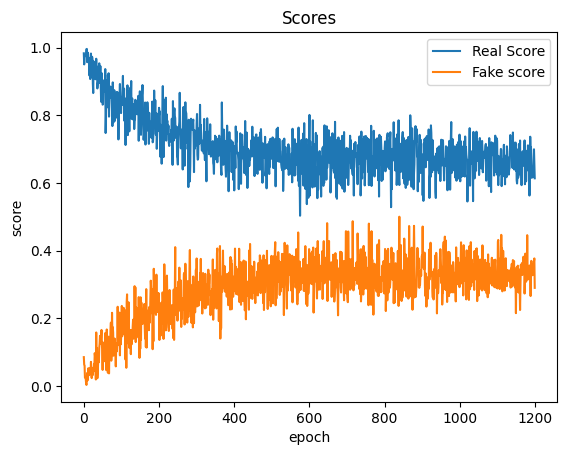

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

#### Step 4. Save the model weights in the folder to be used later.



In [ ]:
torch.save(G.state_dict(), 'generator_model.pth')
torch.save(D.state_dict(), 'discriminator_model.pth')

#### Step 5. Load the model using the saved weights.


In [ ]:
G.load_state_dict(torch.load('generator_model.pth'))
D.load_state_dict(torch.load('discriminator_model.pth'))

<All keys matched successfully>

#### Step 6: Re-train the GAN model to see if you can improve.

In [ ]:
%%time

num_additional_epochs = 300  # Define how many more epochs to train
start_epoch = 400  # Starting from epoch 301
end_epoch = start_epoch + num_additional_epochs
total_num_epoch = end_epoch

total_step = len(data_loader)
#d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(start_epoch, end_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, total_num_epoch, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [400/700], Step [200/600], d_loss: 1.0185, g_loss: 1.3400, D(x): 0.70, D(G(z)): 0.36
Epoch [400/700], Step [400/600], d_loss: 1.0096, g_loss: 1.5642, D(x): 0.70, D(G(z)): 0.36
Epoch [400/700], Step [600/600], d_loss: 0.8569, g_loss: 1.5517, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0401.png
Epoch [401/700], Step [200/600], d_loss: 0.8407, g_loss: 1.4357, D(x): 0.72, D(G(z)): 0.31
Epoch [401/700], Step [400/600], d_loss: 1.0422, g_loss: 1.4140, D(x): 0.63, D(G(z)): 0.33
Epoch [401/700], Step [600/600], d_loss: 1.0272, g_loss: 1.3266, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0402.png
Epoch [402/700], Step [200/600], d_loss: 1.0787, g_loss: 1.4136, D(x): 0.64, D(G(z)): 0.34
Epoch [402/700], Step [400/600], d_loss: 0.9939, g_loss: 1.2926, D(x): 0.67, D(G(z)): 0.32
Epoch [402/700], Step [600/600], d_loss: 1.1824, g_loss: 1.3452, D(x): 0.62, D(G(z)): 0.37
Saving fake_images-0403.png
Epoch [403/700], Step [200/600], d_loss: 1.0467, g_loss: 1.1939, D(x): 0.66, D(G(z)): 0.35
Epoch 

#### Step 7: Save the model weights without using checkpoints.

In [ ]:
torch.save(G.state_dict(), 'generator_model_retrained.pth')
torch.save(D.state_dict(), 'discriminator_model_retrained.pth')

#### Step 8: Load the model weights without using checkpoints.

In [ ]:
G.load_state_dict(torch.load('generator_model_retrained.pth'))
D.load_state_dict(torch.load('discriminator_model_retrained.pth'))

<All keys matched successfully>

Here below are the generated images, after the 420th, 520th, 600th, 650th and 700th epochs of training.

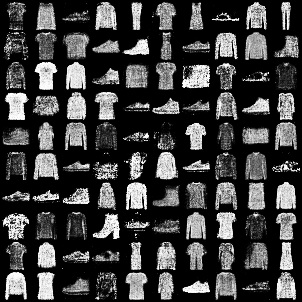

In [ ]:
Image('./samples/fake_images-0420.png')

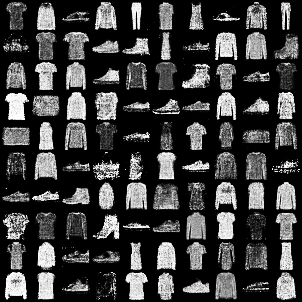

In [ ]:
Image('./samples/fake_images-0520.png')

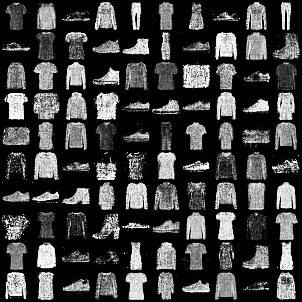

In [ ]:
Image('./samples/fake_images-0600.png')

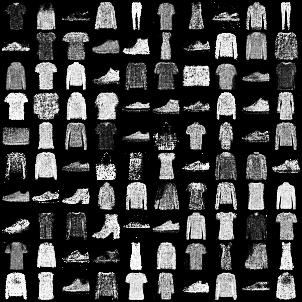

In [ ]:
Image('./samples/fake_images-0650.png')

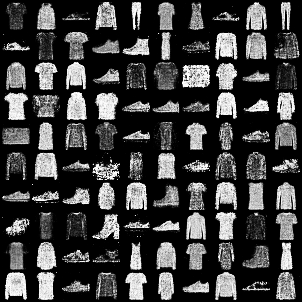

In [ ]:
Image('./samples/fake_images-0700.png')

#### Losses of Discriminator and Generator

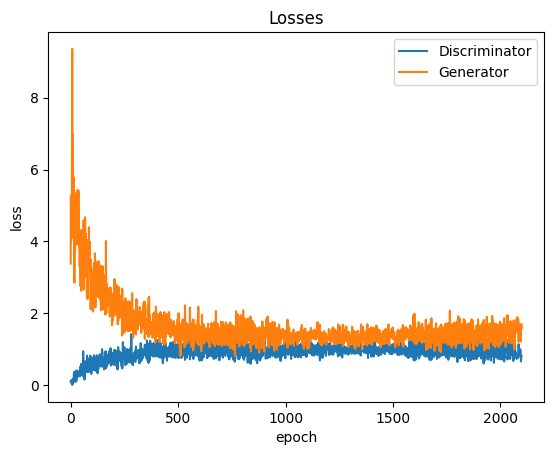

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

#### Real Score Vs Fake Score

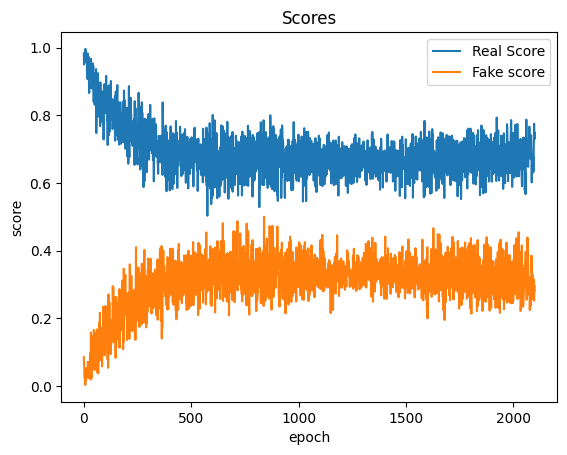

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### Conclusion

LSGAN's least squares loss function results in a training process where the discriminator tries to assign correct labels to both real and generated images (real images as 1, generated images as 0). This loss function is believed to lead to a more stable training process and higher quality generated images.

LSGANs produced higher quality images than traditional GANs when applied to the FashionMNIST dataset. The generated images are typically more realistic and exhibit less variability in quality, due to the more stable training dynamics induced by the least squares loss function.


- Discriminator Loss and Generator loss After 700 epochs in Traditional GAN
- d_loss: 0.8067, g_loss: 1.6887

- Discriminator Loss and Generator loss After 700 epochs in LSGAN
- d_loss: 0.4114, g_loss: 0.4580